In [1]:
from genetic_algorithm import algorithms, selectors, individuals, crossover
from deap import base, creator, tools
import numpy as np
import random

# Definir los parámetros del problema
IND_SIZE = 12  # Número de genes en cada individuo

# Crear los tipos de fitness e individuo en DEAP
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", individuals.truss_like, fitness=creator.FitnessMax)

# Configuración del entorno evolutivo utilizando DEAP
toolbox = base.Toolbox()

# Registro de las funciones
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", lambda: creator.Individual(np.array([[random.choice([0, 1]) for _ in range(IND_SIZE)] for _ in range(2)]),
                                                          var = 0.5))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", lambda ind: ind.evaluate())
toolbox.register("clone", lambda ind: ind.clone())
toolbox.register("mutate", lambda ind: ind.mutate())
toolbox.register("mate", crossover.mix_crossover)
toolbox.register("select", selectors.select_individuals_elitist)

n_pop = 50
pop = toolbox.population(n=n_pop)

hall_of_fame = tools.HallOfFame(1)

# Definir estadísticas
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# _lambda controla la variación en la probabilidad de mutación
population, logbook = algorithms.ea(pop, toolbox, 100, halloffame= hall_of_fame, stats= stats, _lambda = 0.7)

pm:0.0: 100%|██████████| 100/100 [03:04<00:00,  1.85s/it]


Estructura formada por aluminio (azul) y tungsteno (rojo)

Las barras son de 4 y 8 mm de diámetro

bandgap:12.127 kHz


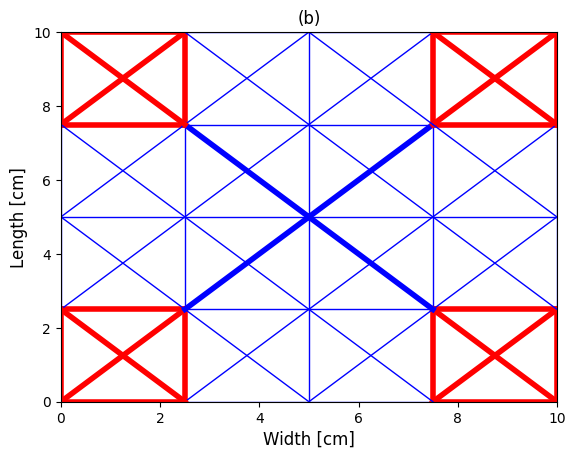

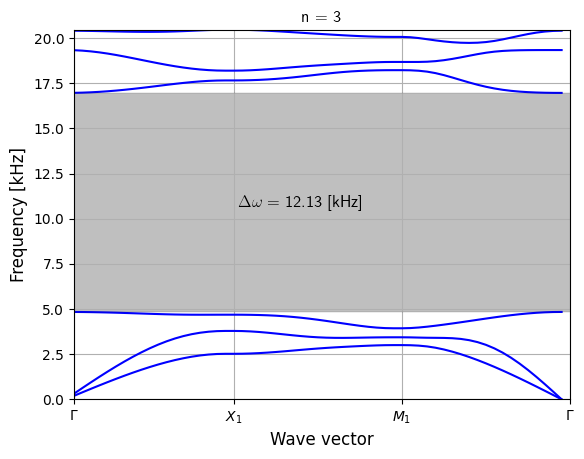

In [2]:
best_individual = hall_of_fame[0]
print(f'bandgap:{best_individual.bandgap:.3f} kHz')
best_individual.plot()


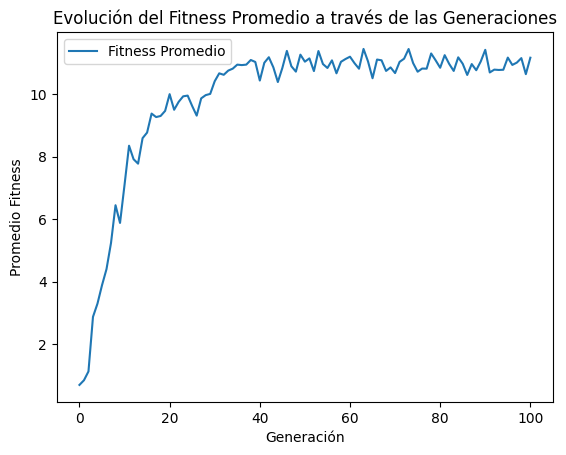

In [3]:
import matplotlib.pyplot as plt

# Supongamos que gen y avg son listas o arrays con los datos de generaciones y promedios
gen, avg = logbook.select("gen", "avg")

# Encuentra el valor máximo de avg y su correspondiente generación
max_avg = max(avg)
max_gen = gen[avg.index(max_avg)]

# Crea la gráfica
plt.plot(gen, avg, label="Fitness Promedio")
plt.xlabel("Generación")
plt.ylabel("Promedio Fitness")
plt.title("Evolución del Fitness Promedio a través de las Generaciones")

# Muestra la leyenda y la gráfica
plt.legend()
plt.show()


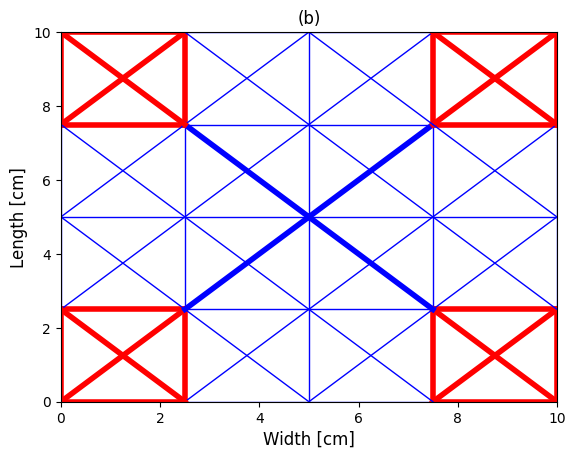

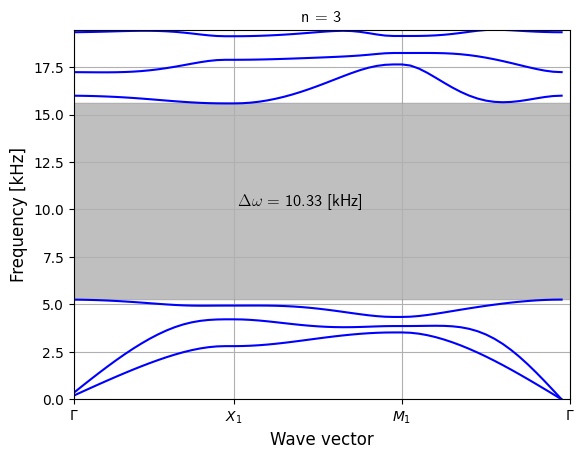

In [4]:
gens_list = [individuo.gens for individuo in population]
avg_gens = np.mean(np.array(gens_list), axis=0)
avg_gens = np.where(avg_gens >= 0.5, 1, 0)
truss = individuals.truss_like(avg_gens, var= 0.5)
truss.evaluate()
truss.plot()